# Survival analysis: the theory


----


Some slides

![](survival/S1.jpg)

![](survival/S2.jpg)

![](survival/S3.jpg)

![](survival/S4.jpg)

![](survival/S5.jpg)

Note: the example is incorrect. It should read $ S_3 = P(X > 105) = 1 \times \frac{4}{5} \times 1 $  

![](survival/S6.jpg)



# A survival analysis example

We will simulate some data on the tenure of subscribers to a digital content platform and then use survival analysis to investigate the effect of the parameters


### Set up environment

In [1]:
%matplotlib inline 
from lifelines import KaplanMeierFitter
import numpy as np, seaborn as sns, pandas as pd, matplotlib.pyplot as plt
import random
random.seed(1234)

### Simulate some survival data for customer subscriptions

In [2]:
n_subscribers = 10000
age = np.random.normal(35, 8, n_subscribers)
gender = np.random.binomial(1, 0.46, n_subscribers)
income = np.random.poisson(25000, n_subscribers)
drama_segment = np.random.binomial(1, 0.22, n_subscribers)
exp_scale = 0.04*age + 4*gender + 0.0002*income + 6*drama_segment
weeks = [np.random.exponential(scale=x, size=1)[0] for x in exp_scale]
cancelled = np.random.binomial(1, 0.8, n_subscribers)

subscribers_df = pd.DataFrame({
    "age": age,
    "gender": gender,
    "income": income,
    "drama_segment": drama_segment,
    "weeks": weeks,
    "cancelled": cancelled
})

subscribers_df.head()

,age,gender,income,drama_segment,weeks,cancelled
0,24.186523,0,24943,1,14.954186,1
1,53.848356,1,25078,0,10.645932,1
2,46.735033,0,25297,0,4.561348,1
3,33.815535,1,25042,1,31.446585,1
4,24.218636,1,25166,0,11.263172,0


A quick look at the distribution of weeks

C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


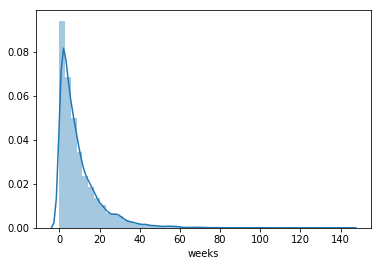

In [3]:
_ = sns.distplot(subscribers_df.weeks)

### A Kaplan-Meier curve for all subscribers

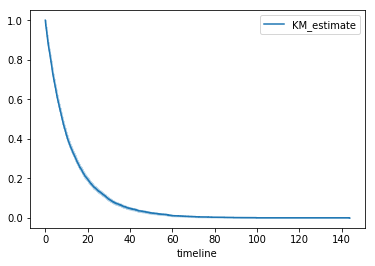

In [4]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
t = subscribers_df.weeks
e = subscribers_df.cancelled
kmf.fit(t, e)
_ = kmf.plot()

By itself this is not particularly interesting. It is more so when we compare groups.

### Kaplan-Meier curves by group

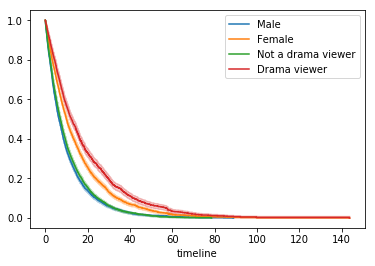

In [5]:
gender_ind = (subscribers_df.gender == 1)
seg_ind = (subscribers_df.drama_segment == 1)

kmf.fit(t[~gender_ind], e[~gender_ind], label='Male')
ax = kmf.plot()

kmf.fit(t[gender_ind], e[gender_ind], label='Female')
ax = kmf.plot(ax=ax)

kmf.fit(t[~seg_ind], e[~seg_ind], label='Not a drama viewer')
ax = kmf.plot(ax=ax)

kmf.fit(t[seg_ind], e[seg_ind], label='Drama viewer')
ax = kmf.plot(ax=ax)

We can run a log rank tests to that differences between groups are statistically significant.

In [6]:
from lifelines.statistics import logrank_test

test_results = logrank_test(t[gender_ind], t[~gender_ind], e[gender_ind], e[~gender_ind], alpha=.99)

test_results.print_summary()


t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p     
      299.0452 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [11]:
test_results_d = logrank_test(t[seg_ind], t[~seg_ind], e[seg_ind], e[~seg_ind], alpha = 0.99)
test_results_d.print_summary()


t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p     
      386.1972 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [13]:
test_results_md = logrank_test(t[~gender_ind], t[~seg_ind], e[~gender_ind], e[~seg_ind], alpha = 0.99)
test_results_md.print_summary()


t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p    
        9.1228 0.0025  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [14]:
test_results_fd = logrank_test(t[gender_ind], t[seg_ind], e[seg_ind], e[gender_ind], alpha = 0.99)
test_results_fd.print_summary()


t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p     
       47.1586 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [15]:
test_results_md2 = logrank_test(t[~gender_ind], t[seg_ind], e[~gender_ind], e[seg_ind], alpha = 0.99)
test_results_md2.print_summary()


t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p     
      413.1557 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [16]:
test_results_fd2 = logrank_test(t[gender_ind], t[~seg_ind], e[gender_ind], e[~seg_ind], alpha = 0.99)
test_results_fd2.print_summary()


t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p     
      259.0092 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


The null hypothesis was no difference. The p-value we obtained was extremely improbable under the null hypothesis.

### A proportional hazards model

The Kaplan-Meier curves allow us to compare the survival of different groups but so far we have not been able to understand the impact of the continuous variables age and income on the survival curves. For this we need the proportional hazards model.

In [7]:
from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(subscribers_df, 'weeks', event_col='cancelled')
cph.print_summary()

n=10000, number of events=7976

                 coef  exp(coef)  se(coef)        z      p  lower 0.95  upper 0.95     
age           -0.0033     0.9967    0.0014  -2.3546 0.0185     -0.0060     -0.0006    *
gender        -0.4452     0.6407    0.0230 -19.3989 0.0000     -0.4902     -0.4002  ***
income        -0.0001     0.9999    0.0001  -0.9888 0.3228     -0.0002      0.0001     
drama_segment -0.5944     0.5519    0.0281 -21.1608 0.0000     -0.6495     -0.5394  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.590
Likelihood ratio test = 795.812 on 4 df, p=0.00000


But how good is the model?

Looking at the p-values of the coefficients only the income variable is not significant.

Another thing we can look at is the concordance index. This is explained in the lifelines documentation as follows: 

> If censorship is present, it’s not appropriate to use a loss function like mean-squared-error or mean-absolute-loss. Instead, one measure is the concordance-index, also known as the c-index. This measure evaluates the accuracy of the ordering of predicted time. It is infact a generalization of AUC, another common loss function, and is interpreted similarly:

> 0.5 is the expected result from random predictions,
1.0 is perfect concordance and,
0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)

So our model is not wonderful but better than random.


### Making predictions

We can now use our model to make predictions about the probability that individuals will last for specific amounts of time.

In [8]:
cph.predict_survival_function(subscribers_df.head(), times=[10., 50., 100.])

,0,1,2,3,4
10.0,0.495752,0.480972,0.316130,0.648867,0.448518
50.0,0.028400,0.024356,0.002895,0.111327,0.017085
100.0,0.000311,0.000220,0.000002,0.006893,0.000098


### Understanding the contributions of the explanatory variables

Lifelines provides a very useful way to understand how an explanatory variable affects the baseline survival.

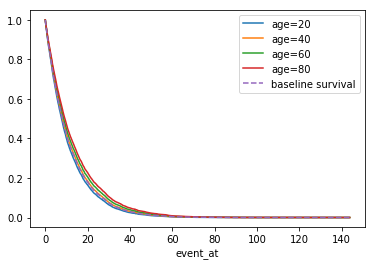

In [9]:
_ = cph.plot_covariate_groups('age', [20, 40, 60, 80])